# Classification using importance-weighted SGPR

This notebook explains how to use Markovflow to build and optimise a GP classifier (in 1D of
course!) using importance-weighted variational inference.

In [1]:
import numpy as np
import tensorflow as tf
from gpflow.ci_utils import ci_niter
from gpflow.likelihoods import Bernoulli

from markovflow.models.iwvi import ImportanceWeightedVI
from markovflow.kernels import Matern32

import matplotlib.pyplot as plt

2022-01-12 11:29:14.495967: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/hostedtoolcache/Python/3.7.12/x64/lib
2022-01-12 11:29:14.496005: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# Setup
learning_rate = 1e-3
importance_K = 10

# toy data
num_data = 100
time_points = np.linspace(0, 10, num_data).reshape(-1,)
observations = np.cos(2*np.pi * time_points / 3.).reshape(-1, 1) + np.random.randn(num_data, 1) * .8
observations = (observations > 0).astype(float)
data = (tf.convert_to_tensor(time_points), tf.convert_to_tensor(observations))

2022-01-12 11:29:16.612505: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-01-12 11:29:16.612763: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/hostedtoolcache/Python/3.7.12/x64/lib
2022-01-12 11:29:16.612780: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-01-12 11:29:16.612805: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (fv-az90-583): /proc/driver/nvidia/version does not exist
2022-01-12 11:29:16.613284: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FM

In [3]:
# model setup
num_inducing = 20
inducing_points = np.linspace(-1, 11, num_inducing).reshape(-1,)
kernel = Matern32(lengthscale=2.0, variance=4.0)
likelihood = Bernoulli()
m = ImportanceWeightedVI(kernel=kernel,
                         inducing_points=tf.constant(inducing_points, dtype=tf.float64),
                         likelihood=likelihood,
                         num_importance_samples=importance_K)

In [4]:
# optimizer setup
variational_variables = m.dist_q.trainable_variables
hyperparam_variables = m.kernel.trainable_variables
adam_variational = tf.optimizers.Adam(learning_rate)
adam_hyper = tf.optimizers.Adam(learning_rate)

_dregs = lambda: -m.dregs_objective(data)
_iwvi_elbo = lambda: -m.elbo(data)

@tf.function
def step():
    adam_variational.minimize(_dregs, var_list=variational_variables)
    adam_hyper.minimize(_iwvi_elbo, var_list=hyperparam_variables)

@tf.function
def elbo_eval():
    return m.elbo(data)

2022-01-12 11:29:16.694586: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [5]:
# a function to plot the data and model fit

def plot(model):

    time_grid = np.linspace(0, 10, 200).reshape(-1,)

    num_samples = 50
    samples_q_s = model.posterior.proposal_process.sample_state(time_grid, num_samples)
    samples_iwvi = model.posterior.sample_f(time_grid, num_samples, input_data=data)

    _, axarr = plt.subplots(2, 1, sharex=True, sharey=True)
    # plot data
    axarr[0].plot(time_points, observations, 'kx')
    axarr[0].set_title('proposal')
    axarr[0].plot(time_grid, samples_q_s[..., 0].numpy().T, alpha=.1, color='red')

    axarr[1].plot(time_points, observations, 'kx')
    axarr[1].set_title('importance-weighted')
    axarr[1].plot(time_grid, samples_iwvi[..., 0].numpy().T, alpha=.1, color='blue')
    axarr[1].set_ylim(-1.5, 2.5)

    # plot mean by numerically integrating the iwvi posterior
    eps = 1e-3
    inv_link = lambda x : eps + (1-eps) * likelihood.invlink(x)
    probs = m.posterior.expected_value(time_grid, data, inv_link)
    axarr[1].plot(time_grid, probs, color='black', lw=1.6)

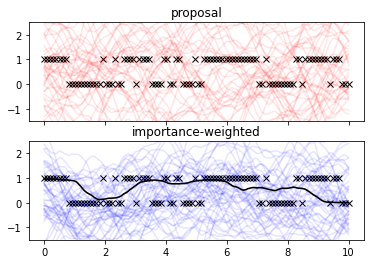

In [6]:
plot(m)

In [7]:
# the optimisation loop
elbos, elbo_stds = [], []
max_iter = ci_niter(2000)
for i in range(max_iter):
    step()
    if i % 10 == 0:
        elbos_i = [elbo_eval().numpy() for _ in range(10)]
        elbos.append(np.mean(elbos_i))
        elbo_stds.append(np.std(elbos_i))
        print(i, elbos[-1], elbo_stds[-1])

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.


Instructions for updating:
`batch_shape` and `event_shape` args are deprecated. Please use `tfd.Sample`, `tfd.Independent`, and broadcasted parameters of the base distribution instead. For example, replace `tfd.TransformedDistribution(tfd.Normal(0., 1.), tfb.Exp(), batch_shape=[2, 3], event_shape=[4])` with `tfd.TransformedDistrbution(tfd.Sample(tfd.Normal(tf.zeros([2, 3]), 1.),sample_shape=[4]), tfb.Exp())` or `tfd.TransformedDistribution(tfd.Independent(tfd.Normal(tf.zeros([2, 3, 4]), 1.), reinterpreted_batch_ndims=1), tfb.Exp())`.


Instructions for updating:
`batch_shape` and `event_shape` args are deprecated. Please use `tfd.Sample`, `tfd.Independent`, and broadcasted parameters of the base distribution instead. For example, replace `tfd.TransformedDistribution(tfd.Normal(0., 1.), tfb.Exp(), batch_shape=[2, 3], event_shape=[4])` with `tfd.TransformedDistrbution(tfd.Sample(tfd.Normal(tf.zeros([2, 3]), 1.),sample_shape=[4]), tfb.Exp())` or `tfd.TransformedDistribution(tfd.Independent(tfd.Normal(tf.zeros([2, 3, 4]), 1.), reinterpreted_batch_ndims=1), tfb.Exp())`.


2022-01-12 11:29:34.861043: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-01-12 11:29:35.035812: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2095074999 Hz


2022-01-12 11:29:36.845625: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:906] Skipping loop optimization for Merge node with control input: assert_equal_29/Assert/AssertGuard/branch_executed/_39


2022-01-12 11:29:43.243842: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:906] Skipping loop optimization for Merge node with control input: assert_equal_29/Assert/AssertGuard/branch_executed/_74


0 -94.73348913227458 15.315564354474269
10 -99.23692600106013 16.69209364613871
20 -92.982793330464 13.485735363119362


30 -91.14853290780533 17.314903575751256
40 -102.32654643824159 16.943336325381768
50 -95.03827895461885 9.1790825477935


60 -93.99872736352559 15.822886515757938
70 -96.13600316850997 18.958523447672206
80 -95.42640535123147 9.939561358316475


90 -87.85040884454472 13.855760511956449
100 -89.31376531514141 7.432272403203422
110 -88.23205695342713 15.309587057878291


120 -90.21552793791003 5.668390218412057
130 -86.59606385857145 12.712470551703667
140 -86.89437989399372 9.807468100135322


150 -93.28552250106891 18.40742531191576
160 -82.59561897800637 7.100615828657722
170 -85.30486940664672 13.520528581384129


180 -87.03289761522784 7.910793099015442
190 -87.68010561443232 8.09814343023131
200 -88.22448379821654 17.007135106852264


210 -94.71862783690122 9.242302054288583
220 -87.1371652424457 11.021769465051955
230 -86.64413874728487 10.929678205308536


240 -77.49336885645276 6.465544585161167
250 -87.12516176681139 11.973073901638532
260 -84.38694248747075 8.030030110635517


270 -86.52072243043744 6.7264738798588795
280 -79.77048030310316 9.34702372356922
290 -84.62726283691406 10.047356440459614


300 -79.09315536215396 9.625027807688728
310 -83.43562629358729 6.208853443182909
320 -74.2092416303478 5.817208251284043


330 -79.84666998532994 6.651412078504035
340 -79.1285827531974 7.9033416243993155
350 -79.22889653445114 7.6417215031490295


360 -76.3553624012251 6.57598157558154
370 -82.56145178362347 8.956141097047762
380 -78.1246799503502 8.232599902308783


390 -77.89583398005284 5.821600243569188
400 -77.56464361932994 6.4261526565227145
410 -74.08682670337296 4.581057764543514


420 -73.04587846841599 6.793349970739966
430 -75.09610101731481 4.067650342420488
440 -71.92401699237703 7.5638255273810255


450 -74.23585561925282 5.48143720643711
460 -75.86299184819646 3.238680631837798
470 -75.44650673326869 8.024520625827144


480 -75.48160967187964 7.400687558148128
490 -74.23030797721017 5.995517288606378
500 -72.58764050176276 7.303981838786912


510 -72.76679103218973 7.728179199501121
520 -71.12849168715833 6.083408382923641
530 -71.67720918725327 7.759231452304223


540 -73.79605075517632 3.9060824846938114
550 -72.33258693923443 6.340338726069299
560 -70.17694237117084 6.734665886092087


570 -73.43918552321826 8.439086384373756
580 -71.23916714972304 5.835727952204508
590 -68.93279710190006 5.23612614267045


600 -72.22152913387932 3.1123224113218346
610 -69.5396326041928 4.431940893539797
620 -72.46613766209474 7.791797744447956


630 -71.09906657875811 3.79825538669747
640 -69.81673827020221 5.189860017406367
650 -72.70384273304579 4.247974616309937


660 -67.25058002964994 3.7036502361109913
670 -69.86298404353931 4.468011669976372
680 -70.3481620289609 5.425503791500369


690 -69.40027118442417 4.585837308466972
700 -68.32550992702794 4.860307535506117
710 -71.8739411688057 5.044162935330015


720 -69.9417356296851 6.5160783607881
730 -68.51300312491055 5.458373316793383
740 -66.59311077062478 3.2318157517674537


750 -69.53595853550783 5.213835813120441
760 -68.49929276130113 4.514902349230735
770 -70.2118628418351 2.171560638222956


780 -72.04239626470994 3.6968000911293286
790 -71.92457661040385 7.7227961101473195
800 -67.62605728485067 5.371259595778924


810 -66.66290460982358 6.1183592037925045
820 -69.54821655979295 4.311007039179703
830 -64.84014644504353 5.869255354153226


840 -68.35583206808383 5.297599385704512
850 -66.9718379705261 3.746670780136802
860 -67.0976675339901 4.303850186977701


870 -66.19924646544172 3.103860803650633
880 -68.64820143305614 4.217388626305285
890 -69.95408118069003 4.119079692252148


900 -66.01403489068281 2.4334454157814216
910 -67.7220659217754 4.933716318193056
920 -66.71197308625975 2.4177635105885122


930 -68.10429290719215 4.516019215876442
940 -67.85336635733272 3.399125006159844
950 -66.71815983379166 3.396601288299641


960 -68.25952897501327 2.846645484514459
970 -67.18681838518056 4.198407522701342
980 -66.35274417609831 3.733717634599735


990 -66.52773393386438 3.807269882467276
1000 -64.73914973637815 2.166376100835719
1010 -66.06389313419695 4.685101409765357


1020 -63.47222558134267 2.991988781068659
1030 -64.80817561393468 2.735855388444863
1040 -64.97805300591678 2.747727468771217


1050 -67.6319096327878 3.25498039856074
1060 -66.40041934591446 3.78336918242592
1070 -65.49722066330814 3.043402476891498


1080 -64.59299694598138 2.2650170830297403
1090 -65.41094965609054 3.472261993737824
1100 -63.860838407386666 2.597054886812856


1110 -67.34084831670782 2.972230016168439
1120 -64.62986254141569 2.661059975968676
1130 -64.58425680366759 3.0088145760719134


1140 -66.5802947287376 2.0123902340959257
1150 -65.23737467171577 2.6616702868551427
1160 -63.60596667779761 2.989862597016777


1170 -65.43490969811828 2.075720359632961
1180 -64.43745031912593 2.815288337204737
1190 -66.00460965595829 3.7905602887231256


1200 -65.6597946362895 3.3724852021341505
1210 -66.23872019061196 3.827796785842109
1220 -63.57610982924062 2.490864119104615


1230 -65.93910769915985 2.2422359098728126
1240 -66.70990672596952 3.1195994533991493
1250 -64.67188938537261 3.467873506834209


1260 -64.73288464017564 3.2043569002428733
1270 -64.12124999477075 4.691395464415462
1280 -66.83292443295122 3.101457246635358


1290 -64.24841100476738 3.004853864696007
1300 -63.098980050978 2.4240254705626385
1310 -63.388337466945245 2.6241022337509796


1320 -64.20041051986894 2.077143099730097
1330 -64.40130862723632 2.8629698159134436
1340 -64.09436951756082 3.2918539409141845


1350 -65.2812928455263 3.31983960583385
1360 -63.023483112995834 2.8367947285905424
1370 -64.4929745438458 2.5070570560946157


1380 -64.73870532988198 2.1718537173752024
1390 -62.35992966032497 3.1514764533219637
1400 -63.1682741756007 1.80590039380016


1410 -65.58910772027828 3.1699396841623777
1420 -63.69130069830599 2.2103811068305923
1430 -63.814271891802534 2.3297459862942254


1440 -63.09541293519387 3.5309515863982774
1450 -62.821664968089635 2.799195510868181
1460 -63.86397492266148 3.8307128749267125


1470 -63.32558131938765 3.463165050798385
1480 -62.78527892908146 2.304789144135507
1490 -63.35025789860591 2.1784597745944985


1500 -63.23469409646286 2.449288492706223
1510 -61.94125956094073 2.169979976800129
1520 -64.1240331399966 3.293917307728735


1530 -62.467163243584466 2.7483239202106127
1540 -62.402207799552244 1.8332139862674335
1550 -62.638078179819715 2.9609596988041416


1560 -62.26602043024461 3.179497432598447
1570 -62.48589881721533 1.4091369567563294
1580 -61.979837576438584 1.6651289304617138


1590 -63.95058350202608 1.6647748413686745
1600 -63.20290736497267 1.0660677913765488
1610 -62.400455691672974 2.454579111148469


1620 -63.56348992760778 1.994139709231719
1630 -61.658925396128915 2.4270652700929807
1640 -62.27861729690328 2.4405426077329944


1650 -61.83576692390549 1.290741586126699
1660 -62.097598151500435 2.3799794341132365
1670 -62.20816584988192 1.8093979027669078


1680 -61.961587418249415 2.1251599555943983
1690 -64.37105551810836 2.8045818683229857
1700 -62.78384857143116 2.1675680346875534


1710 -63.560910577537506 2.3023638317885857
1720 -62.72051948374847 1.3760669175885833
1730 -61.08117145546028 2.15562456302578


1740 -62.25628671289108 3.0329744820652547
1750 -62.688483020987405 1.899641426578888
1760 -63.07626391154231 2.049165029039821


1770 -61.9027533466061 1.2329014411710306
1780 -62.854393581432475 2.652133028788506
1790 -61.31922473113451 1.9159544456925008


1800 -61.234989367937416 2.270596368934249
1810 -61.89147275784918 2.390639918157724
1820 -62.09738464429785 2.0442997799818667


1830 -61.769485237040655 1.5432726494328959
1840 -60.804323603214016 1.4617987641730672
1850 -62.09584776395792 1.6603629971885325


1860 -63.209897283291454 2.4088818288425657
1870 -60.83277811020746 1.979866855024457
1880 -61.560694526601786 2.0721325751354045


1890 -62.10993095709006 1.9625061000064636
1900 -62.83391726419099 1.7148464684457783
1910 -61.40912560532779 1.9723743527051405


1920 -61.73413311085254 1.7476655281193882
1930 -60.957038148455375 2.037061980536353
1940 -62.60078121652663 2.2741316251007535


1950 -62.076237354457135 1.7390151671389844
1960 -60.59954984800841 1.2236712583817704
1970 -62.53952517843878 2.3504606616294126


1980 -61.76808825201606 1.9404816141649963
1990 -61.948361921394294 1.9874307692237014


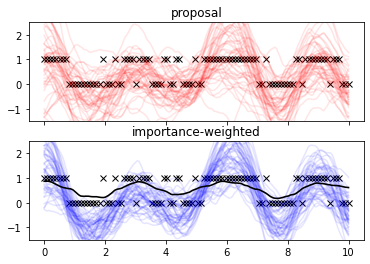

In [8]:
plot(m)